In [45]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

In [47]:
def get_reference_names(df,idx):
    col = f"RUN_{idx:03d}"
    top_100_names = df.sort_values(col,ascending=False).head(100).Name
    return set(top_100_names)

def get_top_100_stats(idx,library,method,ref_names, extra_name=""):    
    filename = f"{library}/{method}_results{extra_name}/{method}_{library.lower()}_{idx:03d}.csv"
    df = pd.read_csv(filename)
    res = []
    for k,v in df.groupby("cycle"):
        res.append(len(v.query("Name in @ref_names")))
    return np.mean(res)

def process_library(lib_name, ref_df, extra_name=""):
    res = []
    for i in tqdm(range(1,111)):
        ref_names = get_reference_names(ref_df,i)
        res.append([i,get_top_100_stats(i,lib_name,"ts",ref_names,extra_name),get_top_100_stats(i,lib_name,"rws",ref_names)])
    return res

### Comparison Set 1
**num_ts_interations** set to 10,000 for both the amide and quinazoline libraries

Read the reference data for the ROCS searches with the amide and quinazoline libraries. 

In [6]:
amide_ref_df = pd.read_parquet("AMIDE/amide_rocs.parquet")
quinaz_ref_df = pd.read_parquet("QUINAZOLINE/quinazoline_rocs.parquet")

See how many of the top 100 molecules we find in the amide library

In [7]:
amide_res = process_library("AMIDE",amide_ref_df)

  0%|          | 0/110 [00:00<?, ?it/s]

See how many of the top 100 molecules we find in the quinazoline library

In [8]:
quinaz_res = process_library("QUINAZOLINE",quinaz_ref_df)

  0%|          | 0/110 [00:00<?, ?it/s]

Calculate the mean top 100 recovery over 110 queries and two libraries

In [9]:
amide_result_df = pd.DataFrame(amide_res,columns=["idx","TS_mean","RWS_mean"])
quinaz_result_df = pd.DataFrame(quinaz_res,columns=["idx","TS_mean","RWS_mean"])

Pivot the data for plotting 

In [10]:
quinaz_summary_df = quinaz_result_df[["idx","TS_mean","RWS_mean"]].melt(id_vars="idx")
quinaz_summary_df.columns = ["Query #","Method","Mean # of Top 100 Found"]
quinaz_summary_df.Method = quinaz_summary_df.Method.str.replace("_mean","")
amide_summary_df = amide_result_df[["idx","TS_mean","RWS_mean"]].melt(id_vars="idx")
amide_summary_df.columns = ["Query #","Method","Mean # of Top 100 Found"]
amide_summary_df.Method = quinaz_summary_df.Method.str.replace("_mean","")

Use lineplots to compare top 100 recovery

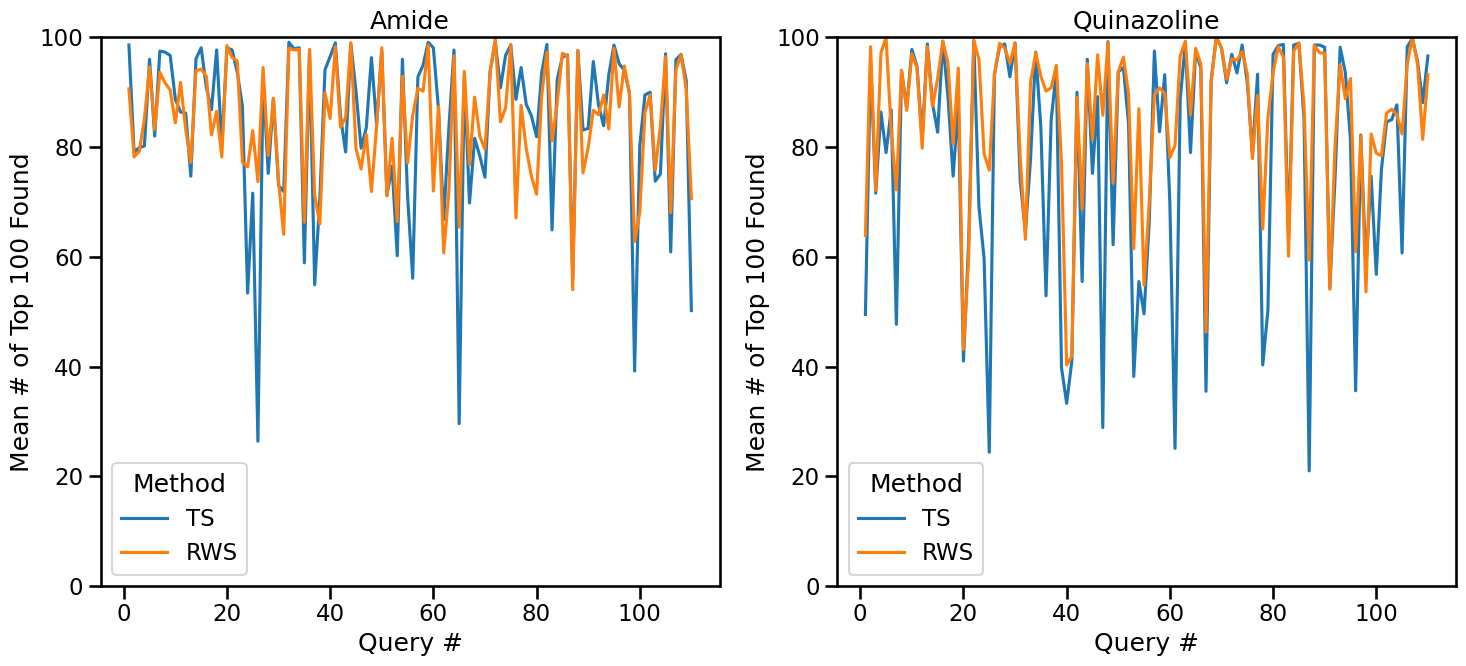

In [11]:
sns.set_context('talk')
figure, axes = plt.subplots(1,2,figsize=(15,7))
ax = sns.lineplot(x="Query #",y="Mean # of Top 100 Found",hue="Method",data=amide_summary_df,ax=axes[0])
ax.set_ylim(0,100)
ax.set_title("Amide")
ax = sns.lineplot(x="Query #",y="Mean # of Top 100 Found",hue="Method",data=quinaz_summary_df,ax=axes[1])
ax.set_ylim(0,100)
ax.set_title("Quinazoline")
plt.tight_layout()

Calculate which method was better over 110 queries. 

In [12]:
amide_result_df['delta'] = amide_result_df.TS_mean-amide_result_df.RWS_mean
amide_result_df['Better'] = pd.cut(amide_result_df.delta,bins=[-100,-5,5,100],labels=["RWS","TIE","TS"])
quinaz_result_df['delta'] = quinaz_result_df.TS_mean-quinaz_result_df.RWS_mean
quinaz_result_df['Better'] = pd.cut(quinaz_result_df.delta,bins=[-100,-5,5,100],labels=["RWS","TIE","TS"])

Display a summary for the amide library

In [13]:
amide_result_df.Better.value_counts()

Better
TIE    65
TS     24
RWS    21
Name: count, dtype: int64

Display a summary for the quinzazoline library

In [17]:
quinaz_result_df.Better.value_counts()

Better
TIE    67
RWS    41
TS      2
Name: count, dtype: int64

Plot the comparison as a histogram

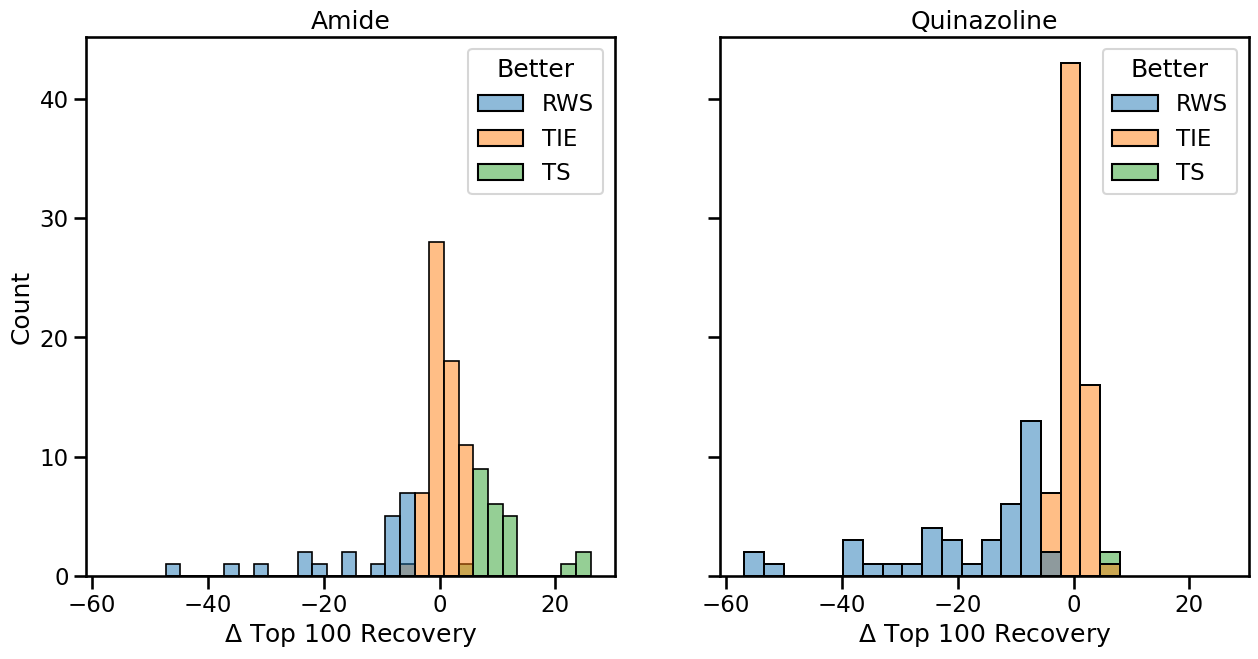

In [16]:
figure, axes =  plt.subplots(1,2,figsize=(15,7),sharex=True,sharey=True)
ax = sns.histplot(x="delta", hue="Better", data=amide_result_df,ax=axes[0])
ax.set_title("Amide")
ax.set_xlabel("$\Delta$ Top 100 Recovery")
ax = sns.histplot(x="delta", hue="Better", data=quinaz_result_df,ax=axes[1])
ax.set_title("Quinazoline")
ax.set_xlabel("$\Delta$ Top 100 Recovery");

### Comparison Set 2
**num_ts_interations** set to 10,000 for the amide library and 18,500 for the quinazoline library

In [48]:
quinaz_18500_res = process_library("QUINAZOLINE",quinaz_ref_df,"_18500")

  0%|          | 0/110 [00:00<?, ?it/s]

Summarize the results

In [34]:
quinaz_18500_result_df = pd.DataFrame(quinaz_18500_res,columns=["idx","TS_mean","RWS_mean"])
quinaz_18500_summary_df = quinaz_18500_result_df[["idx","TS_mean","RWS_mean"]].melt(id_vars="idx")
quinaz_18500_summary_df.columns = ["Query #","Method","Mean # of Top 100 Found"]
quinaz_18500_summary_df.Method = quinaz_18500_summary_df.Method.str.replace("_mean","")

In [41]:
quinaz_18500_result_df.TS_mean.describe()

count    110.000000
mean      83.124545
std       20.099606
min       21.300000
25%       75.975000
50%       91.950000
75%       97.900000
max      100.000000
Name: TS_mean, dtype: float64

In [44]:
len(quinaz_18500_result_df.query("TS_mean >= 50"))

97

In [46]:
ttest_rel(quinaz_18500_result_df.TS_mean, quinaz_18500_result_df.RWS_mean)

TtestResult(statistic=-2.2476965026773783, pvalue=0.026608487565042003, df=109)

Use lineplots to compare top 100 recovery

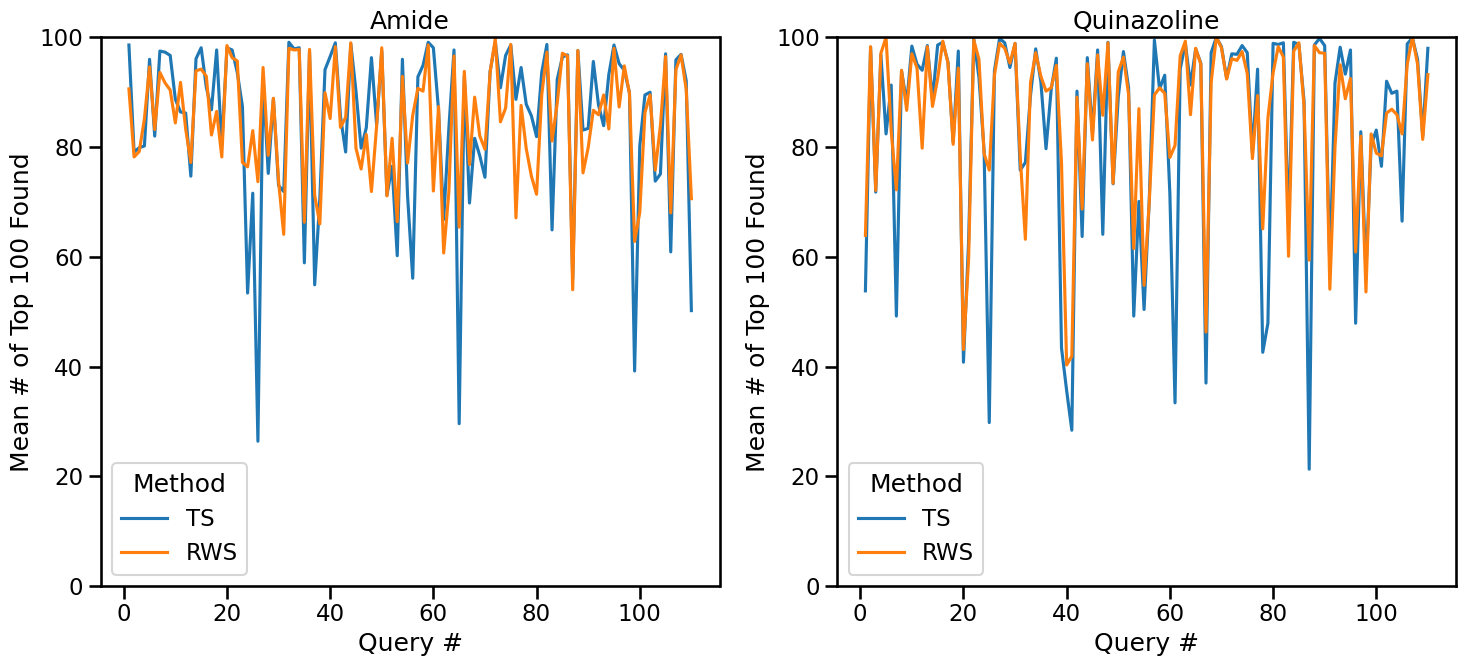

In [35]:
sns.set_context('talk')
figure, axes = plt.subplots(1,2,figsize=(15,7))
ax = sns.lineplot(x="Query #",y="Mean # of Top 100 Found",hue="Method",data=amide_summary_df,ax=axes[0])
ax.set_ylim(0,100)
ax.set_title("Amide")
ax = sns.lineplot(x="Query #",y="Mean # of Top 100 Found",hue="Method",data=quinaz_18500_summary_df,ax=axes[1])
ax.set_ylim(0,100)
ax.set_title("Quinazoline")
plt.tight_layout()

Calculate which method was better over 110 queries. 

In [36]:
quinaz_18500_result_df['delta'] = quinaz_18500_result_df.TS_mean-quinaz_18500_result_df.RWS_mean
quinaz_18500_result_df['Better'] = pd.cut(quinaz_18500_result_df.delta,bins=[-100,-5,5,100],labels=["RWS","TIE","TS"])

In [37]:
quinaz_18500_result_df.Better.value_counts()

Better
TIE    79
RWS    19
TS     12
Name: count, dtype: int64

Text(0.5, 0, '$\\Delta$ Top 100 Recovery')

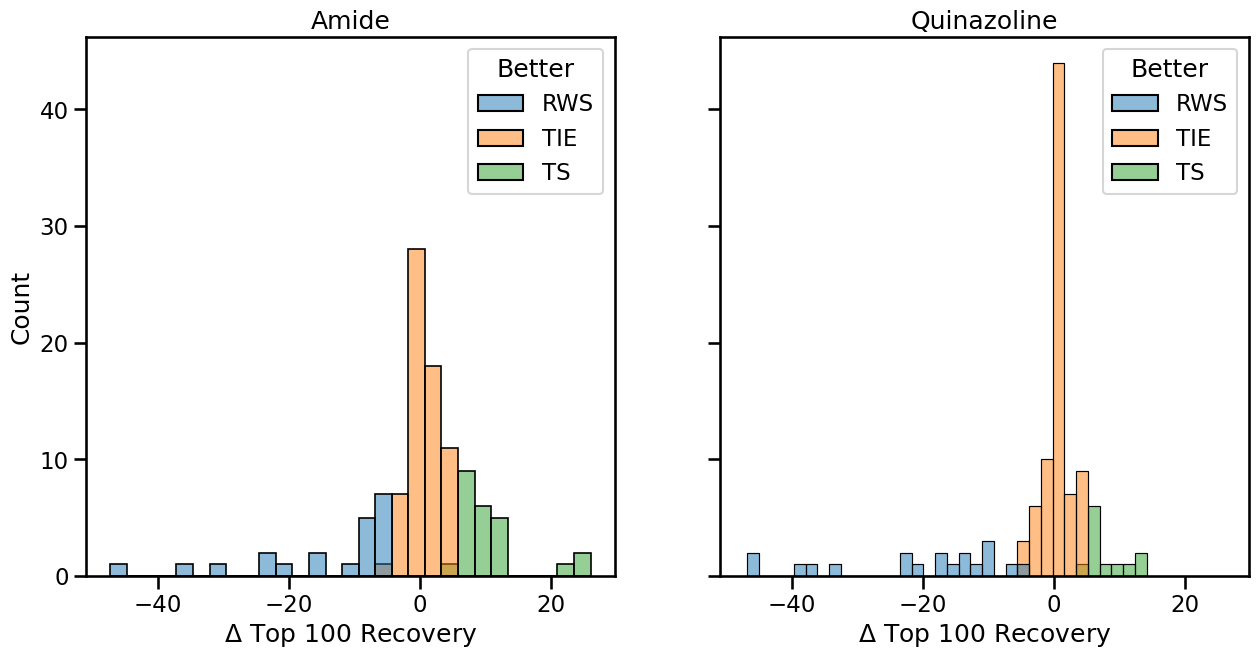

In [38]:
figure, axes =  plt.subplots(1,2,figsize=(15,7),sharex=True,sharey=True)
ax = sns.histplot(x="delta", hue="Better", data=amide_result_df,ax=axes[0])
ax.set_title("Amide")
ax.set_xlabel("$\Delta$ Top 100 Recovery")
ax = sns.histplot(x="delta", hue="Better", data=quinaz_18500_result_df,ax=axes[1])
ax.set_title("Quinazoline")
ax.set_xlabel("$\Delta$ Top 100 Recovery")